In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import arange
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter('ignore')

In [2]:
def calculate_metrics(df, crop_names, y_test, y_pred):
    mae = round(metrics.mean_absolute_error(y_test, y_pred), 3)
    mse = round(metrics.mean_squared_error(y_test, y_pred), 3)
    rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 3)
    r2 = round(r2_score(y_test, y_pred), 3)
    y_test_avg = round(pd.DataFrame(y_test).mean().iloc[0], 3)
    y_pred_avg = round(pd.DataFrame(y_pred).mean().iloc[0], 3)
    df.loc[crop_names] = [mae, mse, rmse, r2, y_test_avg, y_pred_avg]


In [5]:
fao_data = pd.read_csv("~/Documents/Kaleb-Bsc thesis/Crop yield and agricultural practices/datasets/latest0705.csv", index_col='Unnamed: 0')

fao_data

,Nutrient nitrogen N (total) - tonnes,Nutrient phosphate P2O5 (total) - tonnes,Nutrient potash K2O (total) - tonnes,Item,Yield(tonnes/ha),Fung & Bact – Benzimidazoles,"Fung & Bact – Diazines, morpholines",Fung & Bact – Dithiocarbamates,Fung & Bact – Inorganics,Fung & Bact – Other,...,Plant Growth Regulators-1,Plant Growth Regulators-2,Rodenticides – Other-1,Rodenticides – Other-2,Herbicides – Bipiridils-1,Herbicides – Bipiridils-2,Herbicides – Sulfonyl ureas-1,Herbicides – Sulfonyl ureas-2,Rodenticides – Anti-coagulants-1,Rodenticides – Anti-coagulants-2
1990-01-01,0.0,0.0,0.0,Apples,26.3272,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1990-01-01,0.0,0.0,0.0,Apricots,2.5781,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1990-01-01,0.0,0.0,0.0,Cherries,5.0828,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1990-01-01,0.0,0.0,0.0,Currants,7.0383,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
1990-01-01,0.0,0.0,0.0,Gooseberries,6.8081,0.0,0.0,0.0,0.0,0.0,...,1910.0,1910.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-01,0.0,0.0,0.0,Mixed grain,-5.8863,0.0,0.0,0.0,0.0,0.0,...,0.0,144.0,0.0,6.0,0.0,-84.0,0.0,4.0,0.1,0.1
2020-01-01,0.0,0.0,0.0,Oats,0.8941,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1
2020-01-01,0.0,0.0,0.0,Rye,0.9290,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1
2020-01-01,0.0,0.0,0.0,Triticale,0.4421,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.1


In [7]:
fao_data['Crop_season'].value_counts()

Spring        440
Summer        323
Fall          297
Year-Round    246
Winter         31
Name: Crop_season, dtype: int64

In [8]:
cat_names = fao_data['Category'].unique()
cat_names

array(['Fruits and Nuts', 'Vegetables and Legumes', 'Cereals'],
      dtype=object)

In [9]:
quality_metrics = ['RF_MAE', 'RF_MSE', 'RF_RMSE','RF_r2_score', 'y_test_avg', 'y_pred_avg']
error_df = pd.DataFrame(columns = quality_metrics, index = cat_names)
display(error_df)

,RF_MAE,RF_MSE,RF_RMSE,RF_r2_score,y_test_avg,y_pred_avg
Fruits and Nuts,NaN,NaN,NaN,NaN,NaN,NaN
Vegetables and Legumes,NaN,NaN,NaN,NaN,NaN,NaN
Cereals,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
scaler = MinMaxScaler()
for cat in cat_names:
    crop_df = fao_data[fao_data['Category'] == cat]
    encoded_df = pd.get_dummies(crop_df[["Crop_season"]], prefix='', prefix_sep='')
    encoded_df = encoded_df.drop(encoded_df.columns[-2], axis=1)
    y = crop_df[['Yield(tonnes/ha)']]
    x = crop_df.drop(['Yield(tonnes/ha)', "Item", "Category", "Crop_season"], axis=1)
    x = pd.concat([x, encoded_df], axis=1)
    mean = x.mean()
    std = x.std()
    lower_bound = mean - 2 * std
    upper_bound = mean + 2 * std
    x = x.clip(lower_bound, upper_bound, axis=1)
    x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)



    
    regressor = RandomForestRegressor(n_estimators = 500, random_state = 42) #max_depth= 150)
    regressor.fit(x_train, y_train)
    
    #prediction of new value
    y_pred = regressor.predict(x_test)
    calculate_metrics(error_df, cat , pd.DataFrame(y_test), y_pred)
    

In [11]:
encoded_df

,Fall,Spring
1990-01-01,0,1
1990-01-01,0,0
1990-01-01,1,0
1990-01-01,0,1
1990-01-01,1,0
...,...,...
2020-01-01,1,0
2020-01-01,0,1
2020-01-01,1,0
2020-01-01,1,0


In [17]:
error_df

,RF_MAE,RF_MSE,RF_RMSE,RF_r2_score,y_test_avg,y_pred_avg
Fruits and Nuts,3.806,32.836,5.73,0.352,9.623,9.975
Vegetables and Legumes,17.25,828.773,28.788,0.768,45.746,38.371
Cereals,0.587,0.673,0.82,0.885,0.039,0.324


In [15]:
# Create a new Word document
from docx import Document
doc = Document()

# Add a table to the document
table = doc.add_table(rows=4, cols= 7)

# Set the table header row
header_row = table.rows[0]
header_row.cells[0].text = 'Index'
for i, column_name in enumerate(error_df.columns):
    header_row.cells[i+1].text = column_name

# Add the data rows to the table
for _, row in error_df.iterrows():
    data_row = table.add_row().cells
    data_row[0].text = str(row.name)  # Add index value
    for i, value in enumerate(row.values):
        data_row[i+1].text = str(value)

# Save the Word document
doc.save('RF_metrics.docx')

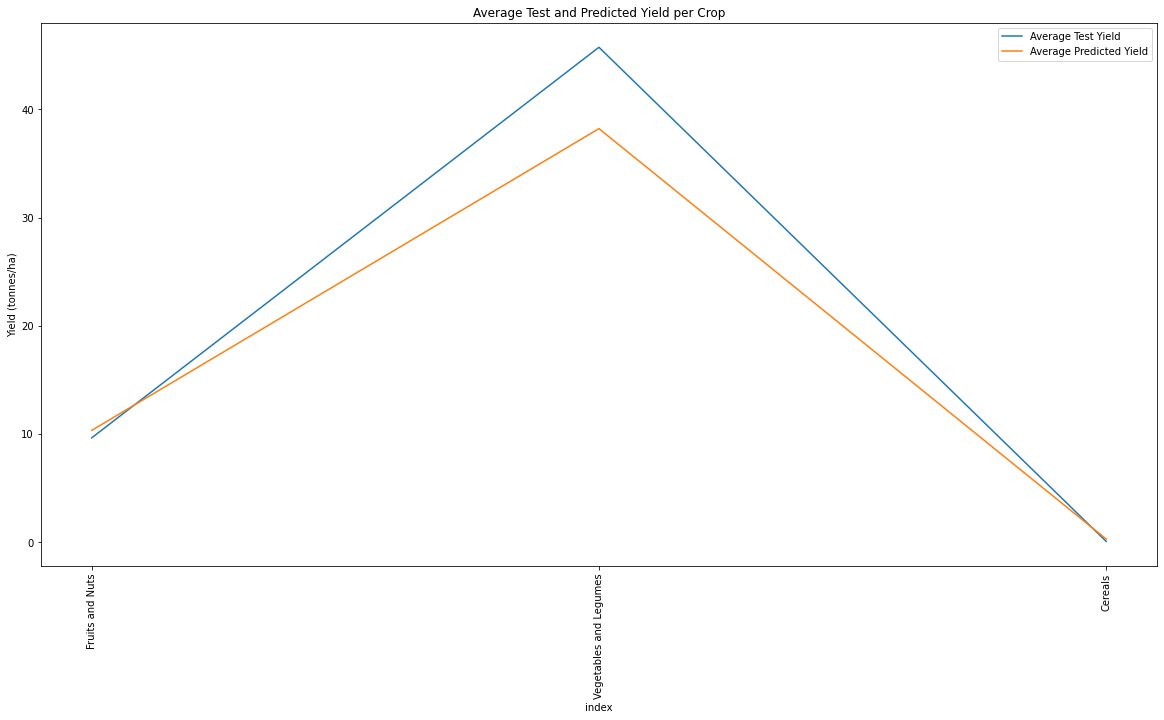

In [15]:
avg_df = error_df[['y_test_avg', 'y_pred_avg']].reset_index()



#create a line plot of the average test and predicted yield per crop
plt.figure(figsize=(20, 10))
plt.plot(avg_df['index'], avg_df['y_test_avg'], label='Average Test Yield')
plt.plot(avg_df['index'], avg_df['y_pred_avg'], label='Average Predicted Yield')
plt.xticks(rotation=90)
plt.xlabel('index')
plt.ylabel('Yield (tonnes/ha)')
plt.title('Average Test and Predicted Yield per Crop')
plt.legend()
plt.show()